In [23]:
%config InlineBackend.figure_formats = ['svg']

In [24]:
import sys
sys.path.insert(0, "..")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets
import modules

In [26]:
class AdaGradOptimizer(modules.Optimizer):

    def __init__(self, lr=0.1) -> None:
        self.lr = 0.1
        self.h = None
    
    def update(self, param: np.ndarray, grad: np.ndarray):
        if self.h is None:
            self.h = np.zeros_like(param)

        self.h = grad ** 2
        param -= self.lr * grad / (np.sqrt(self.h) + 1e-7)

In [27]:
class Params(modules.OptimParams):

    optim_class = AdaGradOptimizer
    params = {
        'lr': 0.01,
    }

In [28]:
class NeuralNetwork(modules.BaseNeuralNetwork):

    def __init__(self, input, hidden, output) -> None:
        self.layers = [
            modules.AffineLayer(input, hidden, Params),
            modules.SigmoidLayer(),
            modules.AffineLayer(hidden, output, Params),
            modules.SigmoidLayer(),
        ]

        self.loss_function = modules.SoftEntropyLayer()

In [29]:
x = np.array([
    [0.01, 0.01],
    [0.01, 0.99],
    [0.99, 0.01],
    [0.99, 0.99],
])
t = np.array([
    [0.45, 0.21],
    [0.01, 0.32],
    [0.50, 0.77],
    [0.17, 0.87],
])

In [30]:
np.seterr(all='ignore')

net = NeuralNetwork(2, 47, 2)

epoch = 2000

loss_list = []
acc_list = []

bar = tqdm(range(epoch))

for e in bar:
    y = net.forward(x)

    r = np.argmax(y, axis=1)

    total = x.shape[0]
    right = np.sum(r == np.argmax(t, axis=1))

    loss = net.loss(y, t)
    dloss = net.dloss()

    dx = net.backward(dloss)

    net.update()

    acc = right / total * 100
    loss_list.append(loss)
    acc_list.append(acc)
    bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:03}%"))

100%|██████████| 2000/2000 [00:02<00:00, 886.53it/s, loss=0.516, acc=100.0%] 


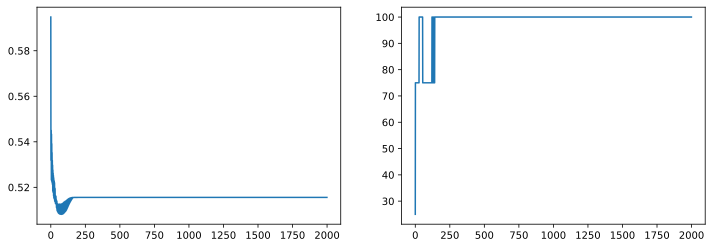

In [31]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [32]:
y = net.forward(x)
print("y:", y)
print('t:', t)

y: [[3.00544411e-09 3.75201089e-10]
 [2.44261669e-15 1.19336230e-09]
 [9.99966167e-01 1.00000000e+00]
 [2.24279189e-09 9.99999998e-01]]
t: [[0.45 0.21]
 [0.01 0.32]
 [0.5  0.77]
 [0.17 0.87]]


In [33]:
x_train, x_test, t_train, t_test = datasets.load_mnist()

In [34]:
np.seterr(all='ignore')

net = NeuralNetwork(784, 47, 10)

batch_size = 64
# train_size = (x_train.shape[0] // batch_size) * batch_size
train_size = batch_size * 20

x_train = x_train[0:train_size]
t_train = t_train[0:train_size]

epoch = 100

loss_list = []
acc_list = []


bar = tqdm(range(epoch))
for e in bar:

    indices = list(range(train_size))

    total = 0
    right = 0

    for _ in range(train_size // batch_size):
        if not indices:
            break

        batch_mask = np.random.choice(indices, batch_size, replace=False)
        for var in batch_mask:
            indices.remove(var)

        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        y = net.forward(x_batch)

        r = np.argmax(y, axis=1)
        total += x_batch.shape[0]
        right += np.sum(r == np.argmax(t_batch, axis=1))

        loss = net.loss(y, t_batch)
        dloss = net.dloss()
        dx = net.backward(dloss)

        net.update()

        acc = right / total * 100
        loss_list.append(loss)
        acc_list.append(acc)

    bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:0.3}%"))


100%|██████████| 100/100 [00:09<00:00, 10.90it/s, loss=1.71, acc=97.6%]


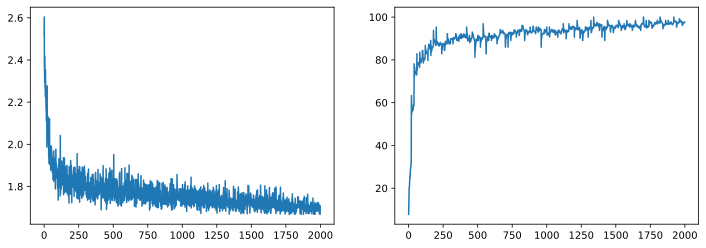

In [35]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [36]:
right = 0
total = 0

for i in range(x_test.shape[0]):
    x = x_test[i]
    t = t_test[i]
    y = net.forward(x)
    l = np.argmax(y)

    total += 1
    if l == np.argmax(t):
        right += 1

print("accuracy:", right / total * 100)


accuracy: 87.26285714285714
